### Import the libraries

In [19]:
from pathlib import Path
from keras.datasets import cifar10
from scipy import ndimage
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

### Data Augmentation function

In [20]:
def augment_dataset(train_images, train_labels, level=12):
    # Flip
    if level >= 2:
        train_images = np.concatenate((train_images, [np.flip(x, axis=1) for x in train_images]))
        train_labels = np.append(train_labels, train_labels)

    # Rotations
    if level >= 6:
        rot15 = [ndimage.interpolation.rotate(x, 15, reshape=False, mode="nearest") for x in train_images]
        rot345 = [ndimage.interpolation.rotate(x, 345, reshape=False, mode="nearest") for x in train_images]
        train_images = np.concatenate((train_images, rot15))
        train_images = np.concatenate((train_images, rot345))
        train_labels = np.append(np.append(train_labels, train_labels), train_labels)

    # Noise
    if level == 12:
        train_images = np.concatenate((train_images, np.random.normal(train_images, 0.03)))
        train_labels = np.append(train_labels, train_labels)

    return train_images, train_labels

### Learning rate scheduler to define a custom learning curve

In [21]:
# Learning rate schedule, change according to training progress
def learning_rate_scheduler(epoch):
    if epoch < 150:
        return 0.001
    if 150 <= epoch < 250:
        return 0.0001
    else:
        return 0.00001

### Function to plot confusion matrix
Source: Scikit-learn documentation

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Hyperparameters

In [30]:
num_classes = 10
epochs = 350
num_checkpoints = 10
# learning_rate = 0.001 -> To be defined inside the learning rate scheduler
batch_size = 500
model_name = "cifar10_resnet18"
verbosity = 2
data_augmentation = False
# Levels: 2 Include Flip, 6 Include Rotation, 12 Include Noise
augmentation_level = 12
training_active = True
print_confusion_matrix = True
print_training_graphs = True
# Dictionary of common parameters used in convolutional layers
params_conv2d = {
        "padding": "SAME",
        "activation": keras.activations.elu
        # 'kernel_regularizer': keras.regularizers.l2(0.01)
}

### Loading, preprocessing and data augmentation

In [31]:
#Load data
(train_images, train_labels) = np.load("data/trnImage.npy"), np.load("data/trnLabel.npy")
(test_images, test_labels) = np.load("data/tstImage.npy"), np.load("data/tstLabel.npy")

#Preprocess data
train_images = np.subtract(np.moveaxis(train_images, -1, 0).flatten(), 1)
test_images = np.subtract(np.moveaxis(test_images, -1, 0).flatten(), 1)

# Dataset augmentation
if data_augmentation:
    train_images, train_labels = augment_dataset(train_images, train_labels, augmentation_level)

# Conversion of labels to one-hot arrays
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

### Define the neural network structure

In [32]:
# Input tensor
x = keras.Input((32, 32, 3))

# conv_1
conv1 = keras.layers.Conv2D(filters=32, kernel_size=7, strides=1, **params_conv2d)(x)
conv1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv1)

# conv_2_x
max_pool = keras.layers.MaxPool2D(padding="SAME")(conv1)
conv2_1 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(max_pool)
conv2_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_1)
conv2_2 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_1)
conv2_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_2)
skip2_1 = keras.layers.BatchNormalization()(keras.layers.add([max_pool, conv2_2]))

conv2_3 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, **params_conv2d)(conv2_2)
conv2_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_3)
conv2_4 = keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, **params_conv2d)(conv2_3)
conv2_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv2_4)

resize2 = keras.layers.Conv2D(filters=32, kernel_size=1, strides=2, padding="SAME")(skip2_1)
skip2_2 = keras.layers.BatchNormalization()(keras.layers.add([resize2, conv2_4]))

# conv_3_x
conv3_1 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip2_2)
conv3_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_1)
conv3_2 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(conv3_1)
conv3_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_2)

resize3_1 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=1, padding="SAME")(skip2_2)
skip3_1 = keras.layers.BatchNormalization()(keras.layers.add([resize3_1, conv3_2]))

conv3_3 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, **params_conv2d)(skip3_1)
conv3_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_3)
conv3_4 = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, **params_conv2d)(conv3_3)
conv3_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv3_4)

resize3_2 = keras.layers.Conv2D(filters=64, kernel_size=1, strides=2, padding="SAME")(skip3_1)
skip3_2 = keras.layers.BatchNormalization()(keras.layers.add([resize3_2, conv3_4]))

# conv_4_x
conv4_1 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip3_2)
conv4_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_1)
conv4_2 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(conv4_1)
conv4_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_2)

resize4_1 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1, padding="SAME")(skip3_2)
skip4_1 = keras.layers.BatchNormalization()(keras.layers.add([resize4_1, conv4_2]))

conv4_3 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, **params_conv2d)(skip4_1)
conv4_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_3)
conv4_4 = keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, **params_conv2d)(conv4_3)
conv4_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv4_4)

resize4_2 = keras.layers.Conv2D(filters=128, kernel_size=1, strides=2, padding="SAME")(skip4_1)
skip4_2 = keras.layers.BatchNormalization()(keras.layers.add([resize4_2, conv4_4]))

# conv_5_x
conv5_1 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip4_2)
conv5_1 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_1)
conv5_2 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(conv5_1)
conv5_2 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_2)

resize5_1 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, padding="SAME")(skip4_2)
skip5_1 = keras.layers.BatchNormalization()(keras.layers.add([resize5_1, conv5_2]))

conv5_3 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, **params_conv2d)(skip5_1)
conv5_3 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_3)
conv5_4 = keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, **params_conv2d)(conv5_3)
conv5_4 = keras.layers.SpatialDropout2D(.5, data_format='channels_last')(conv5_4)

resize5_2 = keras.layers.Conv2D(filters=256, kernel_size=1, strides=1, **params_conv2d)(skip5_1)
skip5_2 = keras.layers.BatchNormalization()(keras.layers.add([resize5_2, conv5_4]))

avg_pool = keras.layers.AvgPool2D(strides=2)(skip5_2)
flat = keras.layers.Flatten()(avg_pool)
dense10 = keras.layers.Dense(10)(flat)
softmax = keras.layers.Softmax()(dense10)

model = keras.Model(inputs=x, outputs=softmax)

### Compile the model and load weights if available

In [33]:
# Loading model weights if available
# if Path("models/" + model_name + '.h5').is_file():
#     print("loading weights")
#     model.load_weights("models/" + model_name + '.h5')

# Model compilation
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

### Define the model callbacks

In [34]:
# Training callbacks
callbacks = [keras.callbacks.LearningRateScheduler(learning_rate_scheduler, verbose=0),
             keras.callbacks.ModelCheckpoint('checkpoints/' + model_name + '.e{epoch:02d}-acc{val_categorical_accuracy:.3f}.h5',
                                             monitor='val_categorical_accuracy',
                                             verbose=0,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='max',
                                             period=epochs//num_checkpoints)
             ]

### Train the model and plot progress and save the weights
Model below is trained on not augmented dataset and for a short period of time.
After 8 hours of training this model with all layers active achieves 65% Top1 accuracy.
With 6 Resnet blocks and 14 layers and the same duration of training the model reaches 72% Top1 accuracy.
Fully trained model is presented on the confusion matrix inside the report.

Train on 10000 samples, validate on 1000 samples
Epoch 1/350
 - 4s - loss: 2.7432 - categorical_accuracy: 0.1032 - top_k_categorical_accuracy: 0.5128 - val_loss: 3.3932 - val_categorical_accuracy: 0.0980 - val_top_k_categorical_accuracy: 0.5450
Epoch 2/350
 - 2s - loss: 2.5609 - categorical_accuracy: 0.1186 - top_k_categorical_accuracy: 0.5477 - val_loss: 4.8530 - val_categorical_accuracy: 0.1140 - val_top_k_categorical_accuracy: 0.5890
Epoch 3/350
 - 2s - loss: 2.4256 - categorical_accuracy: 0.1373 - top_k_categorical_accuracy: 0.5979 - val_loss: 3.4553 - val_categorical_accuracy: 0.1270 - val_top_k_categorical_accuracy: 0.6050
Epoch 4/350
 - 2s - loss: 2.3080 - categorical_accuracy: 0.1709 - top_k_categorical_accuracy: 0.6625 - val_loss: 3.4421 - val_categorical_accuracy: 0.2180 - val_top_k_categorical_accuracy: 0.7450
Epoch 5/350
 - 2s - loss: 2.1934 - categorical_accuracy: 0.1972 - top_k_categorical_accuracy: 0.7214 - val_loss: 3.7957 - val_categorical_accuracy: 0.1910 - val_top_k_

Epoch 43/350
 - 2s - loss: 1.4679 - categorical_accuracy: 0.4701 - top_k_categorical_accuracy: 0.9247 - val_loss: 1.5040 - val_categorical_accuracy: 0.4610 - val_top_k_categorical_accuracy: 0.9240
Epoch 44/350
 - 2s - loss: 1.4616 - categorical_accuracy: 0.4774 - top_k_categorical_accuracy: 0.9215 - val_loss: 1.5157 - val_categorical_accuracy: 0.4630 - val_top_k_categorical_accuracy: 0.9110
Epoch 45/350
 - 2s - loss: 1.4563 - categorical_accuracy: 0.4724 - top_k_categorical_accuracy: 0.9232 - val_loss: 1.5114 - val_categorical_accuracy: 0.4590 - val_top_k_categorical_accuracy: 0.9150
Epoch 46/350
 - 2s - loss: 1.4469 - categorical_accuracy: 0.4725 - top_k_categorical_accuracy: 0.9273 - val_loss: 1.4751 - val_categorical_accuracy: 0.4620 - val_top_k_categorical_accuracy: 0.9260
Epoch 47/350
 - 2s - loss: 1.4410 - categorical_accuracy: 0.4794 - top_k_categorical_accuracy: 0.9271 - val_loss: 1.4955 - val_categorical_accuracy: 0.4690 - val_top_k_categorical_accuracy: 0.9210
Epoch 48/350
 -

Epoch 85/350
 - 2s - loss: 1.1733 - categorical_accuracy: 0.5790 - top_k_categorical_accuracy: 0.9571 - val_loss: 1.3670 - val_categorical_accuracy: 0.5320 - val_top_k_categorical_accuracy: 0.9320
Epoch 86/350
 - 2s - loss: 1.1695 - categorical_accuracy: 0.5765 - top_k_categorical_accuracy: 0.9569 - val_loss: 1.3668 - val_categorical_accuracy: 0.5270 - val_top_k_categorical_accuracy: 0.9350
Epoch 87/350
 - 2s - loss: 1.1464 - categorical_accuracy: 0.5898 - top_k_categorical_accuracy: 0.9610 - val_loss: 1.3820 - val_categorical_accuracy: 0.5390 - val_top_k_categorical_accuracy: 0.9320
Epoch 88/350
 - 2s - loss: 1.1618 - categorical_accuracy: 0.5861 - top_k_categorical_accuracy: 0.9599 - val_loss: 1.3637 - val_categorical_accuracy: 0.5370 - val_top_k_categorical_accuracy: 0.9370
Epoch 89/350
 - 2s - loss: 1.1302 - categorical_accuracy: 0.5881 - top_k_categorical_accuracy: 0.9650 - val_loss: 1.3652 - val_categorical_accuracy: 0.5340 - val_top_k_categorical_accuracy: 0.9340
Epoch 90/350
 -

Epoch 127/350
 - 2s - loss: 0.9363 - categorical_accuracy: 0.6661 - top_k_categorical_accuracy: 0.9769 - val_loss: 1.4229 - val_categorical_accuracy: 0.5500 - val_top_k_categorical_accuracy: 0.9210
Epoch 128/350
 - 2s - loss: 0.9334 - categorical_accuracy: 0.6634 - top_k_categorical_accuracy: 0.9775 - val_loss: 1.4149 - val_categorical_accuracy: 0.5590 - val_top_k_categorical_accuracy: 0.9240
Epoch 129/350
 - 2s - loss: 0.9222 - categorical_accuracy: 0.6682 - top_k_categorical_accuracy: 0.9781 - val_loss: 1.4157 - val_categorical_accuracy: 0.5400 - val_top_k_categorical_accuracy: 0.9250
Epoch 130/350
 - 2s - loss: 0.9221 - categorical_accuracy: 0.6677 - top_k_categorical_accuracy: 0.9793 - val_loss: 1.4363 - val_categorical_accuracy: 0.5460 - val_top_k_categorical_accuracy: 0.9210
Epoch 131/350
 - 2s - loss: 0.9193 - categorical_accuracy: 0.6693 - top_k_categorical_accuracy: 0.9796 - val_loss: 1.4250 - val_categorical_accuracy: 0.5560 - val_top_k_categorical_accuracy: 0.9280
Epoch 132/

Epoch 169/350
 - 2s - loss: 0.7556 - categorical_accuracy: 0.7292 - top_k_categorical_accuracy: 0.9882 - val_loss: 1.4335 - val_categorical_accuracy: 0.5570 - val_top_k_categorical_accuracy: 0.9300
Epoch 170/350
 - 2s - loss: 0.7508 - categorical_accuracy: 0.7303 - top_k_categorical_accuracy: 0.9874 - val_loss: 1.4342 - val_categorical_accuracy: 0.5580 - val_top_k_categorical_accuracy: 0.9300
Epoch 171/350
 - 2s - loss: 0.7477 - categorical_accuracy: 0.7330 - top_k_categorical_accuracy: 0.9877 - val_loss: 1.4360 - val_categorical_accuracy: 0.5610 - val_top_k_categorical_accuracy: 0.9280
Epoch 172/350
 - 2s - loss: 0.7599 - categorical_accuracy: 0.7270 - top_k_categorical_accuracy: 0.9872 - val_loss: 1.4345 - val_categorical_accuracy: 0.5610 - val_top_k_categorical_accuracy: 0.9310
Epoch 173/350
 - 2s - loss: 0.7410 - categorical_accuracy: 0.7355 - top_k_categorical_accuracy: 0.9897 - val_loss: 1.4334 - val_categorical_accuracy: 0.5600 - val_top_k_categorical_accuracy: 0.9300
Epoch 174/

Epoch 211/350
 - 2s - loss: 0.6982 - categorical_accuracy: 0.7450 - top_k_categorical_accuracy: 0.9913 - val_loss: 1.4762 - val_categorical_accuracy: 0.5590 - val_top_k_categorical_accuracy: 0.9310
Epoch 212/350
 - 2s - loss: 0.6871 - categorical_accuracy: 0.7570 - top_k_categorical_accuracy: 0.9909 - val_loss: 1.4782 - val_categorical_accuracy: 0.5610 - val_top_k_categorical_accuracy: 0.9300
Epoch 213/350
 - 2s - loss: 0.7034 - categorical_accuracy: 0.7487 - top_k_categorical_accuracy: 0.9905 - val_loss: 1.4799 - val_categorical_accuracy: 0.5590 - val_top_k_categorical_accuracy: 0.9290
Epoch 214/350
 - 2s - loss: 0.7008 - categorical_accuracy: 0.7486 - top_k_categorical_accuracy: 0.9916 - val_loss: 1.4768 - val_categorical_accuracy: 0.5590 - val_top_k_categorical_accuracy: 0.9310
Epoch 215/350
 - 2s - loss: 0.6933 - categorical_accuracy: 0.7520 - top_k_categorical_accuracy: 0.9899 - val_loss: 1.4774 - val_categorical_accuracy: 0.5530 - val_top_k_categorical_accuracy: 0.9290
Epoch 216/

Epoch 253/350
 - 2s - loss: 0.6590 - categorical_accuracy: 0.7648 - top_k_categorical_accuracy: 0.9913 - val_loss: 1.5151 - val_categorical_accuracy: 0.5690 - val_top_k_categorical_accuracy: 0.9270
Epoch 254/350
 - 2s - loss: 0.6437 - categorical_accuracy: 0.7703 - top_k_categorical_accuracy: 0.9911 - val_loss: 1.5150 - val_categorical_accuracy: 0.5700 - val_top_k_categorical_accuracy: 0.9260
Epoch 255/350
 - 2s - loss: 0.6605 - categorical_accuracy: 0.7631 - top_k_categorical_accuracy: 0.9914 - val_loss: 1.5151 - val_categorical_accuracy: 0.5720 - val_top_k_categorical_accuracy: 0.9250
Epoch 256/350
 - 2s - loss: 0.6457 - categorical_accuracy: 0.7642 - top_k_categorical_accuracy: 0.9922 - val_loss: 1.5147 - val_categorical_accuracy: 0.5730 - val_top_k_categorical_accuracy: 0.9250
Epoch 257/350
 - 2s - loss: 0.6665 - categorical_accuracy: 0.7541 - top_k_categorical_accuracy: 0.9928 - val_loss: 1.5144 - val_categorical_accuracy: 0.5720 - val_top_k_categorical_accuracy: 0.9270
Epoch 258/

Epoch 295/350
 - 2s - loss: 0.6538 - categorical_accuracy: 0.7654 - top_k_categorical_accuracy: 0.9927 - val_loss: 1.5179 - val_categorical_accuracy: 0.5670 - val_top_k_categorical_accuracy: 0.9270
Epoch 296/350
 - 2s - loss: 0.6388 - categorical_accuracy: 0.7686 - top_k_categorical_accuracy: 0.9930 - val_loss: 1.5178 - val_categorical_accuracy: 0.5670 - val_top_k_categorical_accuracy: 0.9270
Epoch 297/350
 - 2s - loss: 0.6457 - categorical_accuracy: 0.7694 - top_k_categorical_accuracy: 0.9933 - val_loss: 1.5180 - val_categorical_accuracy: 0.5660 - val_top_k_categorical_accuracy: 0.9270
Epoch 298/350
 - 2s - loss: 0.6440 - categorical_accuracy: 0.7725 - top_k_categorical_accuracy: 0.9922 - val_loss: 1.5179 - val_categorical_accuracy: 0.5660 - val_top_k_categorical_accuracy: 0.9270
Epoch 299/350
 - 2s - loss: 0.6515 - categorical_accuracy: 0.7721 - top_k_categorical_accuracy: 0.9919 - val_loss: 1.5183 - val_categorical_accuracy: 0.5660 - val_top_k_categorical_accuracy: 0.9270
Epoch 300/

Epoch 337/350
 - 2s - loss: 0.6450 - categorical_accuracy: 0.7692 - top_k_categorical_accuracy: 0.9928 - val_loss: 1.5210 - val_categorical_accuracy: 0.5620 - val_top_k_categorical_accuracy: 0.9270
Epoch 338/350
 - 2s - loss: 0.6446 - categorical_accuracy: 0.7722 - top_k_categorical_accuracy: 0.9925 - val_loss: 1.5213 - val_categorical_accuracy: 0.5640 - val_top_k_categorical_accuracy: 0.9280
Epoch 339/350
 - 2s - loss: 0.6405 - categorical_accuracy: 0.7730 - top_k_categorical_accuracy: 0.9914 - val_loss: 1.5210 - val_categorical_accuracy: 0.5650 - val_top_k_categorical_accuracy: 0.9280
Epoch 340/350
 - 2s - loss: 0.6501 - categorical_accuracy: 0.7654 - top_k_categorical_accuracy: 0.9921 - val_loss: 1.5208 - val_categorical_accuracy: 0.5640 - val_top_k_categorical_accuracy: 0.9270
Epoch 341/350
 - 2s - loss: 0.6404 - categorical_accuracy: 0.7685 - top_k_categorical_accuracy: 0.9930 - val_loss: 1.5212 - val_categorical_accuracy: 0.5630 - val_top_k_categorical_accuracy: 0.9270
Epoch 342/

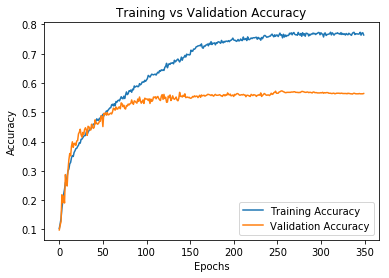

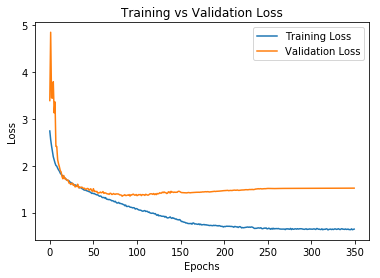

In [35]:
if training_active:
    # Training step
    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        validation_data=(test_images, test_labels),
                        verbose=verbosity,
                        callbacks=callbacks)

    model.save("models/" + model_name + '.h5')
    with open('model_architecture.json', 'w') as f:
        f.write(model.to_json())

    if print_training_graphs:
        # Accuracy over training time
        plt.plot(history.history['categorical_accuracy'], label="Training Accuracy")
        plt.plot(history.history['val_categorical_accuracy'], label="Validation Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        # Loss over training time
        plt.plot(history.history['loss'], label="Training Loss")
        plt.plot(history.history['val_loss'], label="Validation Loss")
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

### Print the confusion matrix

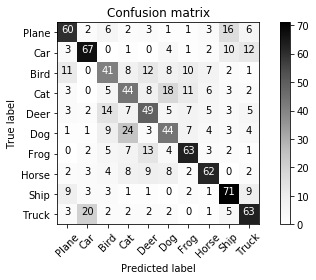

In [37]:
if print_confusion_matrix:
    predictions = np.argmax(model.predict_on_batch(test_images), 1)
    test_labels = np.argmax(test_labels, 1)

    conf_matrix = confusion_matrix(test_labels, predictions)
    plot_confusion_matrix(conf_matrix, ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"], cmap=plt.cm.Greys)
    plt.show()